 ==========================================

In [1]:
# import sys
# import os

# # Получить абсолютный путь к родительской папке
# parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# sys.path.append(parent_dir)

from townsnet import Region

regions_dict = {
  1: 'Ленинградская область',
  # 3138: 'Санкт-Петербург',
  # 3268: 'Москва',
  # 3427: 'Волгоградская область',
  # 3902: 'Тульская область',
  # 4013: 'Омская область',
  # 4437: 'Краснодарский край',
  # 4882: 'Тюменская область',
  # 5188: 'Московская область',
}

regions = {region_id:Region.from_pickle(f'data/regions/{region_id}/{region_id}.pickle') for region_id in regions_dict.keys()}

In [2]:
for region_id, region in regions.items():
  print(region_id, len(region.get_services_gdf()))

1 26602


In [3]:
from townsnet import Provision
from tqdm import tqdm
from multiprocessing import Pool

In [ ]:
for region_id, region in regions.items():
    provision = Provision(region=region)
    st = next(iter(region.service_types))
    print(st.name)

    data_path = f'data/regions/{region_id}/provisions/'
    d_gdf, s_gdf, t_gdf, l_gdf = provision.calculate(st)
    t_gdf['settlement_name'] = t_gdf['settlement_name'].apply(lambda v : None if v==0 else v)
    t_gdf['district_name'] = t_gdf['district_name'].apply(lambda v : None if v==0 else v)
    d_gdf.to_parquet(data_path + f'{st.name}_districts.parquet')
    s_gdf.to_parquet(data_path + f'{st.name}_settlements.parquet')
    t_gdf.to_parquet(data_path + f'{st.name}_towns.parquet')
    l_gdf.to_parquet(data_path + f'{st.name}_links.parquet')


kindergarten


In [8]:
from tqdm import tqdm
import os

i = 0
for region_id, region in regions.items():
    provision = Provision(region=region)
    data_path = f'data/regions/{region_id}/provisions/'
    
    # Создаем директорию, если её нет
    os.makedirs(data_path, exist_ok=True)
    
    # Перебираем ВСЕ service_types в регионе
    for service_type in region.service_types:
        # Вычисляем provision для текущего service_type
        d_gdf, s_gdf, t_gdf, l_gdf = provision.calculate(service_type)
        
        # Обработка данных
        t_gdf['settlement_name'] = t_gdf['settlement_name'].apply(lambda v: None if v == 0 else v)
        t_gdf['district_name'] = t_gdf['district_name'].apply(lambda v: None if v == 0 else v)
        
        # Сохраняем результаты с именем service_type
        st_name = service_type.name
        print(st_name)
        d_gdf.to_parquet(os.path.join(data_path, f'{st_name}_districts.parquet'))
        s_gdf.to_parquet(os.path.join(data_path, f'{st_name}_settlements.parquet'))
        t_gdf.to_parquet(os.path.join(data_path, f'{st_name}_towns.parquet'))
        l_gdf.to_parquet(os.path.join(data_path, f'{st_name}_links.parquet'))
        i += 1
        if i == 3:
            break


kindergarten
school
health_center__dispensary


In [9]:
import pandas as pd
import geopandas as gpd

provision_matrix = pd.read_pickle("provision_matrix_health_center__dispensary.pkl")
print(provision_matrix.head())

cities_gdf = gpd.read_parquet('cities_gdf.parquet')
print(cities_gdf.head())


id  0     1     2     3     4     5     6     7     8     9     ...  2921  \
id                                                              ...         
0      0     0     0     0     0     0     0     0     0     0  ...     0   
1      0     0     0     0     0     0     0     0     0     0  ...     0   
2      0     0     0     0     0     0     0     0     0     0  ...     0   
3      0     0     0     0     0     0     0     0     0     0  ...     0   
4      0     0     0     0     0     0     0     0     0     0  ...     0   

id  2922  2923  2924  2925  2926  2927  2928  2929  2930  
id                                                        
0      0     0     0     0     0     0     0     0     0  
1      0     0     0     0     0     0     0     0     0  
2      0     0     0     0     0     0     0     0     0  
3      0     0     0     0     0     0     0     0     0  
4      0     0     0     0     0     0     0     0     0  

[5 rows x 2931 columns]
   index              

In [ ]:
matrix = pd.concat([provision_matrix, cities_gdf[['name', 'is_anchor_settlement', 'geometry']]], axis=1)
gdf = gpd.GeoDataFrame(matrix, geometry=matrix['geometry'], crs="EPSG:32636")
gdf.to_crs(crs='EPSG:4326', inplace=True)

matrix_T = pd.concat([provision_matrix.T, cities_gdf[['name', 'is_anchor_settlement', 'geometry']]], axis=1)
gdf_T = gpd.GeoDataFrame(matrix_T, geometry=matrix_T['geometry'], crs="EPSG:32636")
gdf_T.to_crs(crs='EPSG:4326', inplace=True)


In [11]:
from tqdm import tqdm
import folium
import geopandas as gpd

def create_anchor_flow_map(matrix: gpd.GeoDataFrame) -> folium.Map:
    # Преобразуем в GeoDataFrame с нужной CRS
    # gdf = gpd.GeoDataFrame(matrix, geometry=matrix['geometry'], crs="EPSG:32636")
    gdf = matrix.copy()

    # Центр карты — по центроиду всех опорных городов
    anchor_points = gdf[gdf['is_anchor_settlement'] == True]['geometry']
    center = anchor_points.unary_union.centroid
    fmap = folium.Map(location=[center.y, center.x], zoom_start=7)

    # Подготовка справочников
    id_to_geom = gdf['geometry'].to_dict()
    id_to_name = gdf['name'].to_dict()
    is_anchor = gdf['is_anchor_settlement'].to_dict()

    # Отображаем перемещения с прогресс-баром
    for from_id in tqdm(gdf.index, desc="Обработка городов"):
        for to_id in gdf.index:
            if not is_anchor.get(to_id, False):
                continue
            value = matrix.at[from_id, to_id]
            if value <= 0:
                continue

            from_point = id_to_geom[from_id]
            to_point = id_to_geom[to_id]

            # Отображаем оба города (если ещё не отображались)
            for city_id in (from_id, to_id):
                point = id_to_geom[city_id]
                folium.CircleMarker(
                    location=(point.y, point.x),
                    radius=6 if is_anchor[city_id] else 4,
                    color="green" if is_anchor[city_id] else "blue",
                    fill=True,
                    fill_opacity=0.7,
                    popup=id_to_name[city_id],
                ).add_to(fmap)

            # Добавляем линию-поток
            folium.PolyLine(
                locations=[(from_point.y, from_point.x), (to_point.y, to_point.x)],
                color="red",
                weight=2 + min(value / 50, 5),
                opacity=0.7,
                tooltip=f"{id_to_name[from_id]} → {id_to_name[to_id]}: {value:.0f}",
            ).add_to(fmap)

    return fmap


In [47]:
# gdf.set_crs(epsg=4326, allow_override=True, inplace=True)
flow_map = create_anchor_flow_map(gdf)
flow_map.save("anchor_flows.html")


Обработка городов: 100%|██████████| 2931/2931 [00:03<00:00, 956.59it/s] 


1. Обеспечивает ли опорный пункт сам себя?

In [25]:
anchor_ids = matrix[matrix['is_anchor_settlement']].index
self_provision = matrix.loc[anchor_ids, anchor_ids]
self_provision

,121,128,259,261,350,449,526,529,630,911,...,1554,1695,1696,1727,1748,1875,2115,2463,2619,2816
121,105,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128,0,263,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
259,0,0,584,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
261,0,0,106,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
449,0,0,0,0,0,655,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
529,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
630,0,0,0,0,0,0,0,0,147,0,...,0,0,0,0,0,0,0,0,0,0
911,0,0,0,0,0,0,0,0,0,109,...,0,0,0,0,0,0,0,0,0,0


2. Ходит ли кто-то из опорного пункта в другие опорные пункты?

In [64]:
anchor_ids = matrix[matrix['is_anchor_settlement']].index

inter_anchor_flows = []

for from_id in anchor_ids:
    for to_id in anchor_ids:
        if from_id != to_id and matrix.at[from_id, to_id] > 0:
            inter_anchor_flows.append((from_id, to_id, matrix.at[from_id, to_id]))


print(f'Count of movements from anchor to anchor: {len(inter_anchor_flows)}')

Count of movements from anchor to anchor: 2


3. Ходит ли кто-то из не-опорных пунктов в другие не-опорные пункты?

In [ ]:
non_anchor_ids = matrix[~matrix['is_anchor_settlement']].index

non_anchor_flows = []

for from_id in non_anchor_ids:
    for to_id in non_anchor_ids:
        if from_id != to_id and matrix.at[from_id, to_id] > 0:
            non_anchor_flows.append((from_id, to_id, matrix.at[from_id, to_id]))


print(f'Count of movements from non-anchor to non-anchor: {len(non_anchor_flows)}')

Count of movements from non-anchor to non-anchor: 893


4. Потоки для опорного пункта

In [28]:
polygon_gdf = gpd.read_parquet("path_to_file.parquet")

In [42]:
from tqdm import tqdm
import folium
import geopandas as gpd

def create_anchor_flow_map(matrix: gpd.GeoDataFrame, polygons_gdf: gpd.GeoDataFrame, anchor_id: int) -> folium.Map:
    """
    Создает карту потоков для опорных пунктов, отображает линки только для указанного города по его ID,
    а также отображает полигоны с полупрозрачной заливкой.

    :param matrix: Матрица перемещений между городами
    :param polygons_gdf: GeoDataFrame с полигонами для отображения на карте
    :param anchor_id: ID города, для которого нужно отображать линки
    :return: folium.Map объект с картой
    """
    # Центр карты — по центроиду опорного города (по ID)
    anchor_points = matrix[matrix['is_anchor_settlement'] == True]['geometry']
    center = anchor_points.unary_union.centroid
    fmap = folium.Map(location=[center.y, center.x], zoom_start=7)

    # Подготовка справочников
    id_to_geom = matrix['geometry'].to_dict()
    id_to_name = matrix['name'].to_dict()
    is_anchor = matrix['is_anchor_settlement'].to_dict()

    # Отображаем полигоны с полупрозрачным цветом
    polygons_gdf = polygons_gdf.to_crs(epsg=4326)
    for _, row in polygons_gdf.iterrows():
        folium.GeoJson(
            row['geometry'],
            style_function=lambda x: {
                'fillColor': 'blue', 'color': 'black', 'weight': 1, 'fillOpacity': 0.3
            }
        ).add_to(fmap)

    # Отображаем перемещения с прогресс-баром
    for from_id in tqdm(matrix.index, desc="Обработка городов"):
        # if from_id != anchor_id:
        #     continue  # Пропускаем города, если их ID не совпадает с anchor_id

        for to_id in matrix.index:
            if to_id != anchor_id:
                continue
            if not is_anchor.get(to_id, False):
                continue
            value = matrix.at[from_id, to_id]
            if value <= 0:
                continue

            from_point = id_to_geom[from_id]
            to_point = id_to_geom[to_id]

            # Отображаем оба города (если ещё не отображались)
            for city_id in (from_id, to_id):
                point = id_to_geom[city_id]
                color = "green" if is_anchor[city_id] else "blue"
                folium.CircleMarker(
                    location=(point.y, point.x),
                    radius=6 if is_anchor[city_id] else 4,
                    color=color,
                    fill=True,
                    fill_opacity=0.7,
                    popup=id_to_name[city_id],
                ).add_to(fmap)

            # Если линки из другого города в опорный пункт, рисуем их другим цветом
            line_color = "orange" if is_anchor[from_id] else "red"
            folium.PolyLine(
                locations=[(from_point.y, from_point.x), (to_point.y, to_point.x)],
                color=line_color,
                weight=2 + min(value / 50, 5),
                opacity=0.7,
                tooltip=f"{id_to_name[from_id]} → {id_to_name[to_id]}: {value:.0f}",
            ).add_to(fmap)

    return fmap


In [43]:
create_anchor_flow_map(gdf, polygon_gdf, 1695) 

Обработка городов: 100%|██████████| 2931/2931 [00:01<00:00, 2235.00it/s]


5. Гистограмма потоков + цветовая шкала (legend)

e:\Github\Job\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3607: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


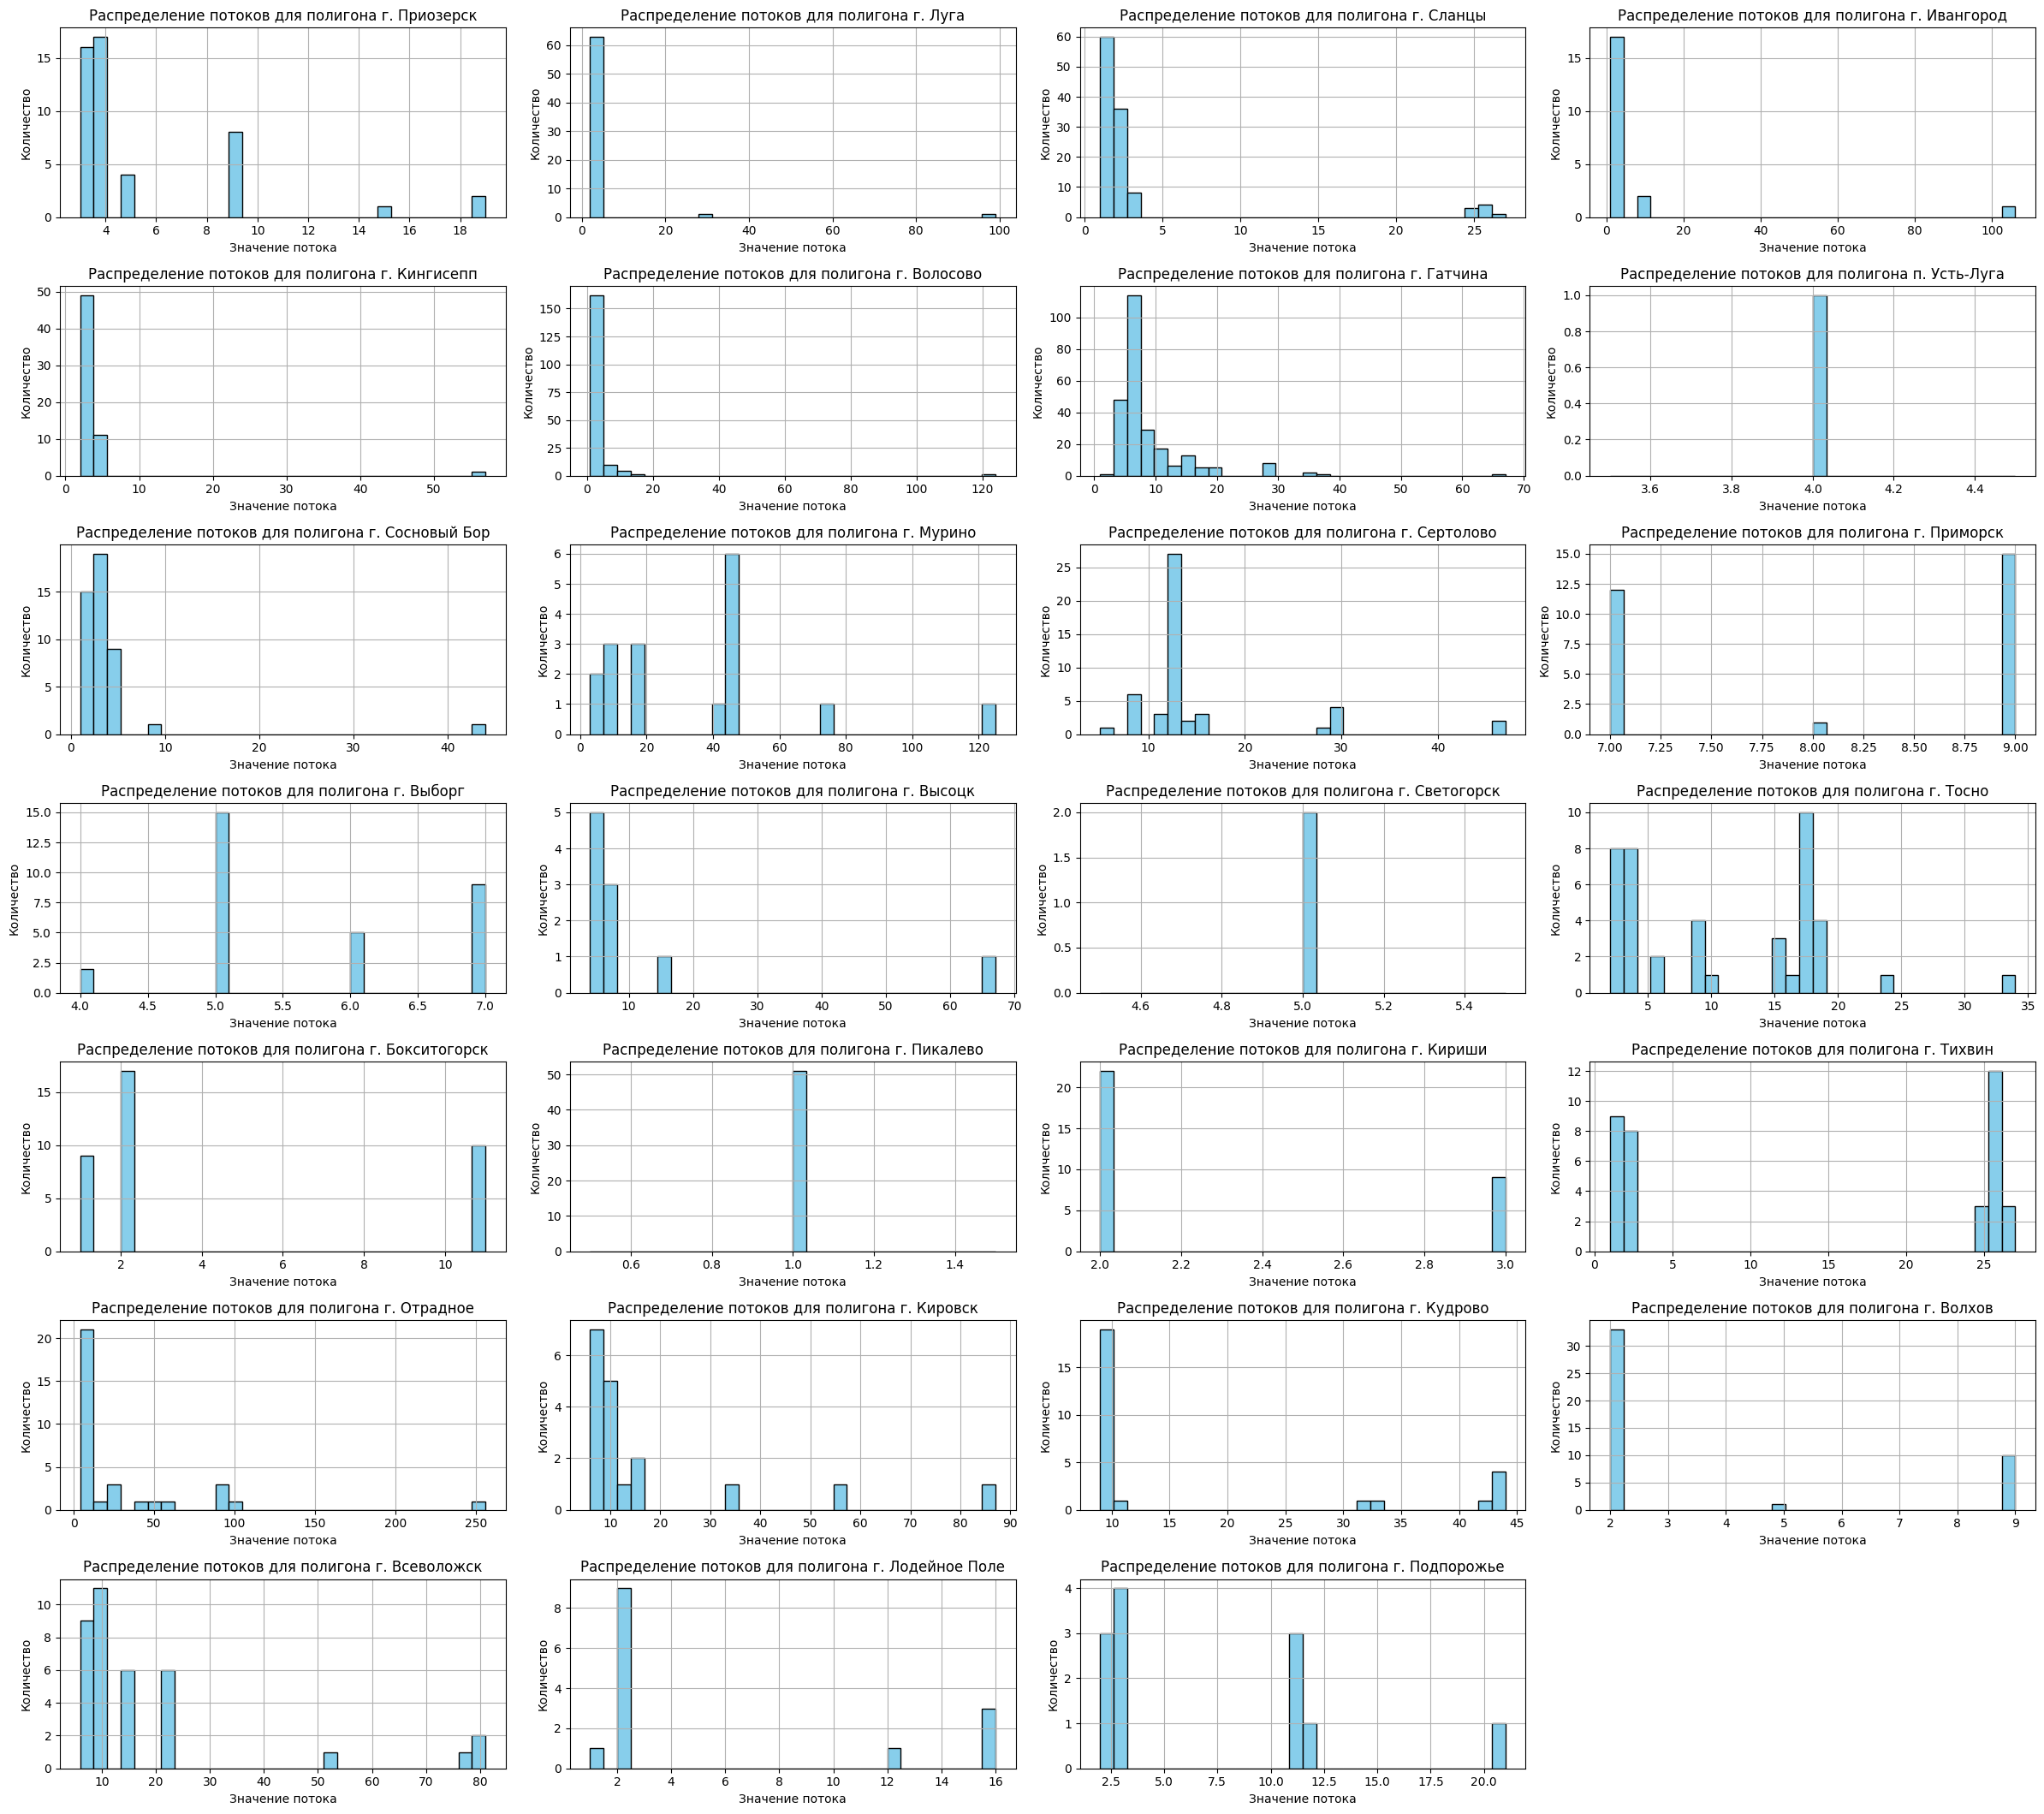

In [61]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Приводим геоданные городов и полигоны к одной CRS
gdf_copy = gdf.copy()
for i in range(gdf_copy.shape[0]):
    gdf_copy.iloc[i, i] = 0
gdf_copy = gdf_copy.to_crs(polygon_gdf.crs)

# Пространственное объединение (sjoin) для разделения городов по полигонам
gdf_with_polygon = gpd.sjoin(gdf_copy, polygon_gdf, how="inner", op="within")

# Группировка по полигонам
grouped = gdf_with_polygon.groupby('index_right')  # 'index_right' - это индекс полигона из polygon_gdf

# Создаем график с подграфиками
num_plots = len(grouped)
ncols = 4  # Количество столбцов
nrows = (num_plots + 1) // 2  # Количество строк (округляем в большую сторону)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, nrows * 3))

# Плоский список осей для удобства
axes = axes.flatten()

# Строим гистограмму для каждой группы
for i, (polygon_id, group) in enumerate(grouped):
    # Извлечение всех потоков для данной группы
    anchor_name = group['anchor_name'].iloc[0]
    flows = group.drop(columns=['name', 'geometry', 'is_anchor_settlement', 'index_right', 'anchor_name'])
    flow_values = flows.values.flatten()
    flow_values = flow_values[flow_values > 0]  # только положительные потоки

    # Построение гистограммы на соответствующей оси
    axes[i].hist(flow_values, bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f"Распределение потоков для полигона {anchor_name}")
    axes[i].set_xlabel("Значение потока")
    axes[i].set_ylabel("Количество")
    axes[i].grid(True)

# Убираем пустые оси, если количество подграфиков меньше, чем места
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Обеспечиваем общий вид
plt.tight_layout()
plt.show()


6. Метрики

In [80]:
towns_gdf = gpd.read_parquet('cities_gdf.parquet')
towns_gdf

,index,geometry,id,name,is_anchor_settlement,parent_id,parent_name,population,soc_workers_dev,soc_workers_soc,...,soc_old_dev,soc_old_soc,soc_old_bas,soc_parents_dev,soc_parents_soc,soc_parents_bas,index_right,basic,additional,comfort
0,0,POINT (543142.339 6580637.744),207,деревня Болото,False,6.0,Борское сельское поселение,10.0,None,0.033795,...,0.194644,0.041469,0.072120,0.308008,0.033795,0.002834,0,0.33,0.6,0.4
1,1,POINT (544532.929 6593228.214),208,деревня Большой Остров,False,6.0,Борское сельское поселение,68.0,None,0.033795,...,0.194644,0.041469,0.072120,0.308008,0.033795,0.002834,1,0.67,0.7,0.4
2,2,POINT (544895.402 6593052.876),209,деревня Бор,False,6.0,Борское сельское поселение,1734.0,None,0.033795,...,0.194644,0.041469,0.072120,0.308008,0.033795,0.002834,2,0.67,0.7,0.4
3,3,POINT (543993.111 6589582.121),210,деревня Бороватое,False,6.0,Борское сельское поселение,10.0,None,0.033795,...,0.194644,0.041469,0.072120,0.308008,0.033795,0.002834,3,0.53,0.7,0.4
4,4,POINT (538540.110 6576793.684),211,деревня Бочево,False,6.0,Борское сельское поселение,10.0,None,0.033795,...,0.194644,0.041469,0.072120,0.308008,0.033795,0.002834,4,0.20,0.6,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2926,2926,POINT (399059.742 6560341.471),3133,деревня Апраксин Бор,False,205.0,Трубникоборское сельское поселение,313.0,None,0.152398,...,0.271781,0.105424,0.491682,0.335392,0.152398,0.226743,2926,0.20,0.4,0.2
2927,2927,POINT (403967.171 6562087.081),3134,деревня Александровка,False,205.0,Трубникоборское сельское поселение,313.0,None,0.152398,...,0.271781,0.105424,0.491682,0.335392,0.152398,0.226743,2927,0.27,0.4,0.4
2928,2928,POINT (413116.740 6573793.279),3135,деревня Большая Горка,False,205.0,Трубникоборское сельское поселение,313.0,None,0.152398,...,0.271781,0.105424,0.491682,0.335392,0.152398,0.226743,2928,0.27,0.4,0.2
2929,2929,POINT (412458.032 6574811.307),3136,деревня Дроздово,False,205.0,Трубникоборское сельское поселение,5.0,None,0.152398,...,0.271781,0.105424,0.491682,0.335392,0.152398,0.226743,2929,0.27,0.4,0.2


In [84]:
test = pd.concat([gdf_T, towns_gdf['population']], axis=1)

In [ ]:
test[test["is_anchor_settlement"]][:]

,0,1,2,3,4,5,6,7,8,9,...,2925,2926,2927,2928,2929,2930,name,is_anchor_settlement,geometry,population
121,2,2,2,2,0,0,0,0,2,2,...,0,0,0,0,0,0,г. Бокситогорск,True,POINT (33.84753 59.47381),15494.0
128,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,г. Пикалево,True,POINT (34.17817 59.51296),20731.0
259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,г. Кингисепп,True,POINT (28.60121 59.37805),47969.0
261,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,г. Ивангород,True,POINT (28.21971 59.37649),10736.0
350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,п. Усть-Луга,True,POINT (28.26664 59.65768),2365.0
449,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,г. Кириши,True,POINT (32.00872 59.44969),52411.0
526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,г. Кировск,True,POINT (30.98146 59.87533),25704.0
529,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,г. Отрадное,True,POINT (30.79455 59.77409),25480.0
630,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,г. Лодейное Поле,True,POINT (33.54589 60.73455),20047.0
911,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,г. Подпорожье,True,POINT (34.16693 60.91276),17441.0


In [107]:
test.loc[test[test['is_anchor_settlement']].index, :].drop(columns=['name','is_anchor_settlement','geometry']).sum(axis=1)

121     15744.0
128     21052.0
259     48952.0
261     10736.0
350      2365.0
449     53137.0
526     25704.0
529     25480.0
630     20273.0
911     17595.0
1030    19094.0
1060    64360.0
1061    12212.0
1262    39944.0
1543    77239.0
1547    59302.0
1549    79762.0
1554    49963.0
1695    81008.0
1696     1105.0
1727     5745.0
1748    15780.0
1875    95857.0
2115    36496.0
2463    33752.0
2619    58847.0
2816    39577.0
dtype: float64

 ==========================================

In [ ]:
for region_id, region in tqdm(regions.items()):
  provision = Provision(region=region)
  
  def calculate_provision(st):
    data_path = f'data/regions/{region_id}/provisions/'
    d_gdf, s_gdf, t_gdf, l_gdf = provision.calculate(st)
    t_gdf['settlement_name'] = t_gdf['settlement_name'].apply(lambda v : None if v==0 else v)
    t_gdf['district_name'] = t_gdf['district_name'].apply(lambda v : None if v==0 else v)
    d_gdf.to_parquet(data_path + f'{st.name}_districts.parquet')
    s_gdf.to_parquet(data_path + f'{st.name}_settlements.parquet')
    t_gdf.to_parquet(data_path + f'{st.name}_towns.parquet')
    l_gdf.to_parquet(data_path + f'{st.name}_links.parquet')
  
  with Pool() as pool:
    pool.map(calculate_provision, next(iter(region.service_types)))

  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
import geopandas as gpd
import pandas as pd

source = 'https://www.openstreetmap.org/'
period = '2023'

for region_id, region_name in regions_dict.items():
  data_path = f'data/regions/{region_id}/'
  region = regions[region_id]
  st_df = region.get_service_types_df()
  values = []
  for i,infrastructure in enumerate(st_df.infrastructure.unique()):
    st_sub_df = st_df[st_df.infrastructure == infrastructure]
    for j, st_name in enumerate(st_sub_df.name):
      code = f'5.{i+1}.{j+1}'
      d_gdf = gpd.read_parquet(data_path + f'provisions/{st_name}_districts.parquet')
      s_gdf = gpd.read_parquet(data_path + f'provisions/{st_name}_settlements.parquet')
      t_gdf = gpd.read_parquet(data_path + f'provisions/{st_name}_towns.parquet')
      l_gdf = gpd.read_parquet(data_path + f'provisions/{st_name}_links.parquet')
      total = Provision.total_provision(d_gdf)
      values.append({
        '№ п/п': code,
        'Значение': round(total,2) if total is not None else None,
        'Территория': region_name,
        'Источник': source,
        'Период': period,
      })
      for district_id in d_gdf.index:
        district_name = d_gdf.loc[district_id, 'name']
        total = d_gdf.loc[district_id, 'provision']
        values.append({
          '№ п/п': code,
          'Значение': round(total,2) if total is not None else None,
          'Территория': district_name,
          'Источник': source,
          'Период': period,
        })
      for settlement_id in s_gdf.index:
        settlement_name = s_gdf.loc[settlement_id, 'name']
        total = s_gdf.loc[settlement_id, 'provision']
        values.append({
          '№ п/п': code,
          'Значение': round(total,2) if total is not None else None,
          'Территория': settlement_name,
          'Источник': source,
          'Период': period,
        })
  values_df = pd.DataFrame(values)
  values_df.to_excel(data_path+f'{region_id} {region_name}.xlsx', index=False)

In [5]:
region = regions[1]

In [6]:
from shapely import set_precision
from statistics import mean

def get_region_provisions(region, region_id):
  data_path = f'data/regions/{region_id}/provisions/'
  d_gdfs = []
  s_gdfs = []
  t_gdfs = []
  for st in region.service_types:
    prov_col = f'provision_{st.name}'

    d_gdf = gpd.read_parquet(data_path + f'{st.name}_districts.parquet')[['geometry', 'name', 'provision']].rename(columns={
      'provision': f'provision_{st.name}',
      'name': 'district_name'
    })
    d_gdf[prov_col] = d_gdf[prov_col].apply(lambda p : round(p,2))
    d_gdfs.append(d_gdf)

    s_gdf = gpd.read_parquet(data_path + f'{st.name}_settlements.parquet')[['geometry', 'name', 'provision']].rename(columns={
      'provision': f'provision_{st.name}',                                                                                                                               
      'name': 'settlement_name'
    })
    s_gdf[prov_col] = s_gdf[prov_col].apply(lambda p : round(p,2))
    s_gdfs.append(s_gdf)

    t_gdf = gpd.read_parquet(data_path + f'{st.name}_towns.parquet')[['geometry', 'town_name', 'provision']].rename(columns={'provision': f'provision_{st.name}'})
    t_gdf[prov_col] = t_gdf[prov_col].apply(lambda p : round(p,2))
    t_gdfs.append(t_gdf)

  d_gdf = d_gdfs[0][['geometry', 'district_name']]
  s_gdf = s_gdfs[0][['geometry', 'settlement_name']]
  t_gdf = t_gdfs[0][['geometry', 'town_name']]

  d_gdf = pd.concat([d_gdf, *[gdf[filter(lambda c : 'provision' in c, gdf.columns)] for gdf in d_gdfs]], axis=1)
  s_gdf = pd.concat([s_gdf, *[gdf[filter(lambda c : 'provision' in c, gdf.columns)] for gdf in s_gdfs]], axis=1)
  t_gdf = pd.concat([t_gdf, *[gdf[filter(lambda c : 'provision' in c, gdf.columns)] for gdf in t_gdfs]], axis=1)

  for gdf in [d_gdf, s_gdf, t_gdf]:
    gdf['provision'] = gdf[filter(lambda c : 'provision' in c, gdf.columns)].apply(mean, axis=1).apply(lambda p : round(p, 2))
    gdf.to_crs(4326, inplace=True)
    gdf['geometry'] = set_precision(gdf['geometry'], grid_size=0.0001)

  return d_gdf, s_gdf, t_gdf

In [7]:
for region_id, region in regions.items():
  data_path = f'data/regions/{region_id}/provisions/'
  d_gdf, s_gdf, t_gdf = get_region_provisions(region, region_id)
  d_gdf.to_file(data_path + 'districts.geojson')
  s_gdf.to_file(data_path + 'settlements.geojson')
  t_gdf.to_file(data_path + 'towns.geojson')

In [8]:
region = Region.from_pickle('data/regions/1/1.pickle')
region.settlements

,geometry,name
0,"MULTIPOLYGON (((580049.515 6617067.720, 580225...",Самойловское сельское поселение
1,"MULTIPOLYGON (((573514.444 6620389.851, 573579...",Большедворское сельское поселение
2,"MULTIPOLYGON (((564707.328 6594903.594, 564341...",Пикалевское городское поселение
3,"MULTIPOLYGON (((560629.509 6557332.762, 560642...",Борское сельское поселение
4,"MULTIPOLYGON (((560659.317 6585430.874, 559919...",Бокситогорское городское поселение
...,...,...
183,"MULTIPOLYGON (((360431.648 6619592.469, 360583...",Фёдоровское городское поселение
184,"MULTIPOLYGON (((387941.398 6612286.590, 388009...",Нурминское сельское поселение
185,"MULTIPOLYGON (((363803.737 6614904.469, 363821...",Красноборское городское поселение
186,"MULTIPOLYGON (((392924.072 6551507.217, 393174...",Трубникоборское сельское поселение
